## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint


import matplotlib.pyplot as plt, seaborn as sb

import spacy
import re

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

from sklearn.decomposition import NMF

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json","r")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


In [ ]:
#print the column names
print(list(df.columns))

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [ ]:
#Assign new column names
columns = list(df.columns)
new_columns = []
for column in columns:
    if '.' in column:
        new_columns.append(column.split('.')[1])
    else:
        new_columns.append(column.split('_')[1])

df.columns = new_columns

df.columns


Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [ ]:
df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [ ]:
df[df.complaint_what_happened == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78304,complaint-public-v2,complaint,3080086,0.0,None,76107,3080086,Applying for a mortgage or refinancing an exis...,2018-11-22T12:00:00-05:00,TX,N/A,Mortgage,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-11-22T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Other
78305,complaint-public-v2,complaint,3103013,0.0,Older American,863XX,3103013,Closing an account,2018-12-17T12:00:00-05:00,AZ,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-18T12:00:00-05:00,None,Other banking product or service,Yes,,Funds not received from closed account,Consent not provided
78306,complaint-public-v2,complaint,3099437,0.0,None,11217,3099437,Managing an account,2018-12-12T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2018-12-18T12:00:00-05:00,None,Checking account,Yes,,Deposits and withdrawals,N/A
78307,complaint-public-v2,complaint,3156336,0.0,None,074XX,3156336,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-02-19T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Other


In [ ]:
#Assign nan in place of blanks in the complaints column
df.complaint_what_happened = df.complaint_what_happened.apply(lambda x: np.nan if x=='' else x)
df.complaint_what_happened

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [ ]:
#Remove all rows where complaints column is nan
df = df[~df.complaint_what_happened.isnull()]

In [ ]:
##print final shape
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once we have removed all the blank complaints, we need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once we have done these cleaning operations we need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [ ]:
# Converting to lowercase.
df.complaint_what_happened = df.complaint_what_happened.apply(lambda x: x.lower())
df.complaint_what_happened

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in xx/xx/2018 and...
10       chase card was reported on xx/xx/2019. however...
11       on xx/xx/2018, while trying to book a xxxx  xx...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday, xx/xx/xxxx i called chas, my xxx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for 30 yrs. i've ha...
78312    roughly 10+ years ago i closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [ ]:
#removing square brackets and word containing in the brackets
df.complaint_what_happened=df.complaint_what_happened.apply(lambda x: re.sub(r'\[.*\]',"",x))
df.complaint_what_happened

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in xx/xx/2018 and...
10       chase card was reported on xx/xx/2019. however...
11       on xx/xx/2018, while trying to book a xxxx  xx...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday, xx/xx/xxxx i called chas, my xxx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for 30 yrs. i've ha...
78312    roughly 10+ years ago i closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [ ]:
#removing punctuations and special
df.complaint_what_happened=df.complaint_what_happened.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x))
df.complaint_what_happened

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in xxxx2018 and w...
10       chase card was reported on xxxx2019 however fr...
11       on xxxx2018 while trying to book a xxxx  xxxx ...
14       my grand son give me check for 160000 i deposi...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday xxxxxxxx i called chas my xxxx xx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for 30 yrs ive had ...
78312    roughly 10 years ago i closed out my accounts ...
Name: complaint_what_happened, Length: 21072, dtype: object

In [ ]:
#removing words containing numbers
df.complaint_what_happened=df.complaint_what_happened.apply(lambda x:re.sub(r'\w*\d\w*',"",x))
df.complaint_what_happened

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in  and was told ...
10       chase card was reported on  however fraudulent...
11       on  while trying to book a xxxx  xxxx  ticket ...
14       my grand son give me check for  i deposit it i...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday xxxxxxxx i called chas my xxxx xx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for  yrs ive had ch...
78312    roughly  years ago i closed out my accounts wi...
Name: complaint_what_happened, Length: 21072, dtype: object

In [ ]:
#function to Lemmatize the texts
lemmatizer = WordNetLemmatizer()
df['lemmatized_complaints'] = df.complaint_what_happened.apply(lambda text: ' '.join([lemmatizer.lemmatize(token) for token in word_tokenize(text)]))
df.lemmatized_complaints

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in and wa told by...
10       chase card wa reported on however fraudulent a...
11       on while trying to book a xxxx xxxx ticket i c...
14       my grand son give me check for i deposit it in...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday xxxxxxxx i called chas my xxxx xx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for yr ive had chas...
78312    roughly year ago i closed out my account with ...
Name: lemmatized_complaints, Length: 21072, dtype: object

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened','lemmatized_complaints']]
print(df_clean.complaint_what_happened.iloc[50])
print("-"*50)
print(df_clean.lemmatized_complaints.iloc[50])

i purchased tickets  using my xxxx xxxx xxxx chase credit card  for my family of four and my two parents to go overseas from the us to xxxx for the first time last fall i purchased through a discount airline  xxxx  as it would not have been financially possible with another carrier our tickets were round trip not purchased as individual one way fares four tickets were purchased for my family on xxxxxxxx  and my parents tickets were purchased xxxxxxxx all six of us flew from the us xxxxxxxx my family of four were set to return xxxxxxxx with my parents set to return xxxxxxxx as xxxx airlines began experiencing financial difficulties they started changing and cancelling flights my return was cancelled because my flight from xxxx to xxxx wasnt being flown i was told by xxxx if i could get to xxxx on another airline i could catch a flight from xxxx back to the us with xxxx needing to get back to work as a teacher i booked  flights from xxxx to xxxx at my own expense two days later xxxx fail

In [ ]:
df_clean

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...


In [ ]:
# Write your function to extract the POS tags only NOUNs and NO PRONOUNS
nlp = spacy.load("en_core_web_sm")
def extract_NOUNS(sent):
    return ' '.join([token.text for token in nlp(sent) if token.pos_ == "NOUN"])
print("Lemmatized: ",df_clean.lemmatized_complaints.iloc[0])
print("="*100)
print("Extracted NOUNs: ",extract_NOUNS(df_clean.lemmatized_complaints.iloc[0]))

Lemmatized:  good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
Extracted NOUNs:  morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thanks advance help


In [ ]:
# lets apply the extract_NOUNS function on the lemmatized complaints column
df_clean["complaint_Nouns"]=df_clean['lemmatized_complaints'].apply(lambda x: extract_NOUNS(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_Nouns
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase year banking merchant ...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit credit card chase freedom xxxx problem ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
df_clean['char_len']=df_clean.complaint_Nouns.apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_Nouns,char_len
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,156
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,105
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,67
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,330
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,132
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,196
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,583
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase year banking merchant ...,594
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit credit card chase freedom xxxx problem ...,478


Let's have a look at the histogram of the character length of all the complaints

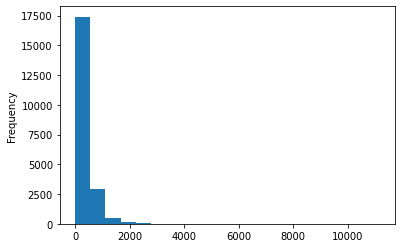

In [ ]:
df_clean.char_len.plot.hist(bins=20)

In [ ]:
df_clean.char_len.describe()

count    21072.000000
mean       356.752373
std        406.581479
min          0.000000
25%        132.000000
50%        250.000000
75%        448.000000
max      11169.000000
Name: char_len, dtype: float64



1.   We can see that most of the complaints are within **3000** characters
2.   Also the **75% percentile is 441 characters**, which means that only almost 25% above 441.
3.   Average is around 250 characters



### Let's now work on the top words to see what kind of words are frequently repeating

In [ ]:
#Taking only the noun sentences to see the distribution
all_words = df_clean.complaint_Nouns.str.split().values.tolist()
all_words = [w for seq in all_words for w in seq]

In [ ]:
#getting each word count using FreqDist fro nltk
top40 = nltk.FreqDist(all_words).most_common(40)
top40

[('account', 46677),
 ('chase', 35338),
 ('credit', 31866),
 ('card', 30075),
 ('payment', 20986),
 ('time', 15976),
 ('bank', 15602),
 ('day', 12657),
 ('charge', 11967),
 ('money', 11927),
 ('xxxx', 10604),
 ('loan', 10483),
 ('check', 10196),
 ('information', 9600),
 ('letter', 9444),
 ('fee', 8629),
 ('number', 8569),
 ('transaction', 8477),
 ('month', 8436),
 ('amount', 8365),
 ('year', 8223),
 ('customer', 8104),
 ('mortgage', 7972),
 ('balance', 7642),
 ('phone', 7508),
 ('company', 7473),
 ('report', 6821),
 ('fund', 6813),
 ('service', 6798),
 ('fraud', 6716),
 ('claim', 6541),
 ('call', 6415),
 ('email', 5820),
 ('business', 5387),
 ('interest', 5312),
 ('issue', 5227),
 ('xxxxxxxx', 5221),
 ('statement', 5207),
 ('complaint', 4968),
 ('branch', 4896)]

In [ ]:
type(dict(top40)['account'])

int

#### Find the top 40 words by frequency among all the articles after processing the text.

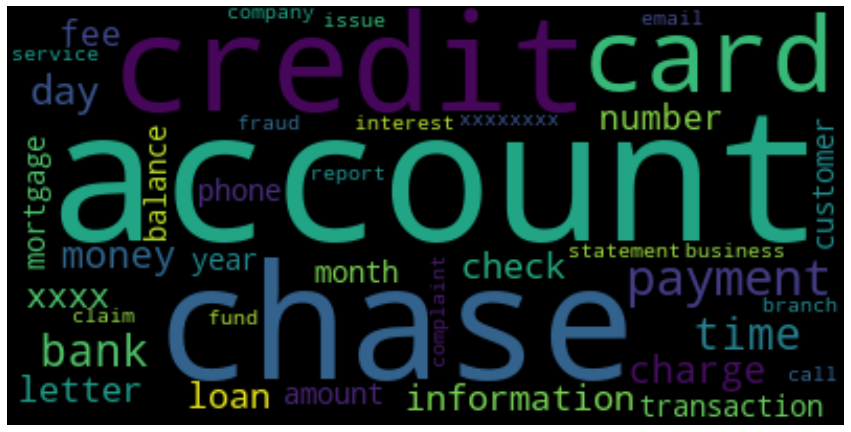

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
cloud = WordCloud()
cloud.generate_from_frequencies(dict(top40))

plt.figure(figsize=(15,20))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see words like account,credit,check,information... which are being dominating amongst all the nouns

### Let's find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
nltk.FreqDist(all_words).most_common(30)

[('account', 46677),
 ('chase', 35338),
 ('credit', 31866),
 ('card', 30075),
 ('payment', 20986),
 ('time', 15976),
 ('bank', 15602),
 ('day', 12657),
 ('charge', 11967),
 ('money', 11927),
 ('xxxx', 10604),
 ('loan', 10483),
 ('check', 10196),
 ('information', 9600),
 ('letter', 9444),
 ('fee', 8629),
 ('number', 8569),
 ('transaction', 8477),
 ('month', 8436),
 ('amount', 8365),
 ('year', 8223),
 ('customer', 8104),
 ('mortgage', 7972),
 ('balance', 7642),
 ('phone', 7508),
 ('company', 7473),
 ('report', 6821),
 ('fund', 6813),
 ('service', 6798),
 ('fraud', 6716)]

In [ ]:
#Print the top 10 words in the unigram frequency
nltk.FreqDist(all_words).most_common(10)

[('account', 46677),
 ('chase', 35338),
 ('credit', 31866),
 ('card', 30075),
 ('payment', 20986),
 ('time', 15976),
 ('bank', 15602),
 ('day', 12657),
 ('charge', 11967),
 ('money', 11927)]

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = list(nltk.bigrams(all_words))
nltk.FreqDist(bigrams).most_common(30)

[(('credit', 'card'), 12552),
 (('credit', 'report'), 3792),
 (('customer', 'service'), 2800),
 (('account', 'account'), 2739),
 (('chase', 'credit'), 2488),
 (('chase', 'account'), 2428),
 (('account', 'chase'), 2280),
 (('checking', 'account'), 2230),
 (('bank', 'account'), 2129),
 (('debit', 'card'), 1850),
 (('card', 'account'), 1806),
 (('credit', 'score'), 1705),
 (('account', 'credit'), 1648),
 (('phone', 'call'), 1589),
 (('payment', 'payment'), 1533),
 (('chase', 'card'), 1474),
 (('money', 'account'), 1458),
 (('card', 'card'), 1437),
 (('interest', 'rate'), 1293),
 (('card', 'credit'), 1264),
 (('phone', 'number'), 1241),
 (('account', 'number'), 1216),
 (('card', 'chase'), 1174),
 (('business', 'day'), 1158),
 (('card', 'company'), 1115),
 (('saving', 'account'), 1075),
 (('fund', 'account'), 1073),
 (('charge', 'account'), 1070),
 (('mortgage', 'payment'), 1063),
 (('credit', 'bureau'), 1039)]

We can see words like credit report, customer service which are relevant to banking domain

In [ ]:
#Print the top 10 words in the bigram frequency
nltk.FreqDist(bigrams).most_common(10)

[(('credit', 'card'), 12552),
 (('credit', 'report'), 3792),
 (('customer', 'service'), 2800),
 (('account', 'account'), 2739),
 (('chase', 'credit'), 2488),
 (('chase', 'account'), 2428),
 (('account', 'chase'), 2280),
 (('checking', 'account'), 2230),
 (('bank', 'account'), 2129),
 (('debit', 'card'), 1850)]

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = list(nltk.trigrams(all_words))
nltk.FreqDist(trigrams).most_common(30)

[(('chase', 'credit', 'card'), 1838),
 (('credit', 'card', 'account'), 1108),
 (('credit', 'card', 'company'), 942),
 (('credit', 'card', 'credit'), 617),
 (('inquiry', 'credit', 'report'), 541),
 (('card', 'credit', 'card'), 528),
 (('account', 'credit', 'card'), 524),
 (('credit', 'card', 'chase'), 514),
 (('charge', 'credit', 'card'), 396),
 (('credit', 'report', 'credit'), 384),
 (('credit', 'reporting', 'agency'), 366),
 (('account', 'credit', 'report'), 340),
 (('credit', 'card', 'payment'), 329),
 (('credit', 'card', 'card'), 320),
 (('customer', 'service', 'representative'), 310),
 (('account', 'chase', 'account'), 269),
 (('credit', 'card', 'balance'), 268),
 (('payment', 'credit', 'card'), 267),
 (('credit', 'card', 'charge'), 255),
 (('chase', 'customer', 'service'), 252),
 (('victim', 'identity', 'theft'), 251),
 (('credit', 'card', 'statement'), 231),
 (('credit', 'card', 'year'), 215),
 (('checking', 'saving', 'account'), 211),
 (('freedom', 'credit', 'card'), 204),
 (('c

In [ ]:
#Print the top 10 words in the trigram frequency
nltk.FreqDist(trigrams).most_common(10)

[(('chase', 'credit', 'card'), 1838),
 (('credit', 'card', 'account'), 1108),
 (('credit', 'card', 'company'), 942),
 (('credit', 'card', 'credit'), 617),
 (('inquiry', 'credit', 'report'), 541),
 (('card', 'credit', 'card'), 528),
 (('account', 'credit', 'card'), 524),
 (('credit', 'card', 'chase'), 514),
 (('charge', 'credit', 'card'), 396),
 (('credit', 'report', 'credit'), 384)]

Most of the trigrams are revolving around credit card

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
#regex to remove words starting with minimu one x
df_clean['Complaint_clean'] = df_clean.complaint_Nouns.apply(lambda x: re.sub('x+', '', x))
df_clean.Complaint_clean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1        morning name stop bank cardmember service debt...
2        card agent anniversary date agent information ...
10       card application identity consent service cred...
11       ticket offer ticket reward card information of...
14       son chase account fund bank account money son ...
                               ...                        
78303    chase card customer decade solicitation credit...
78309    card provider claim purchase protection benefi...
78310    pay risk consumer chase year banking merchant ...
78311    credit credit card chase freedom  problem bala...
78312    year account order line credit account payment...
Name: Complaint_clean, Length: 21072, dtype: object

In [ ]:
#check if any empty complaints after removal of x*
df_clean[df_clean.Complaint_clean.isnull()]

,complaint_what_happened,lemmatized_complaints,complaint_Nouns,char_len,Complaint_clean


In [ ]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_Nouns,char_len,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,156,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent information ...,105,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,67,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,330,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son chase account fund bank account money son ...,132,son chase account fund bank account money son ...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,196,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,583,card provider claim purchase protection benefi...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase year banking merchant ...,594,pay risk consumer chase year banking merchant ...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,credit credit card chase freedom xxxx problem ...,478,credit credit card chase freedom problem bala...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 
vect = TfidfVectorizer(stop_words='english',max_df=0.95,min_df=3) ## working with 95% occuring words and ignoring ones which are not in atleast 3 documents


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean.Complaint_clean)
pd.DataFrame(X.toarray(),columns=vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aaaratings,abandonment,abide,abiding,ability,absence,absurdity,abundance,abuse,ac,acccount,acceleration,accent,accept,acceptance,access,accessibility,accessory,accident,accommodation,accomplice,accont,accord,accordance,according,accou,account,accountability,accountand,accountant,accountchase,accountholder,accountholders,accounti,accounting,accountshe,accountsince,accout,accrual,accrue,...,wood,word,wording,work,workday,worker,workforce,working,workmanship,workout,workplace,worksheet,workshop,world,worry,worth,worthiness,wouldbe,wound,wrap,wreck,wrist,writ,write,writeoff,writer,writing,wrong,wrongdoing,wwwchasecom,yard,yea,year,years,yesterday,yield,yr,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.086609,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077617,0.0,0.0,0.0,0.0,0.0,0.036783,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.041572,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Dictioary length : 4487 Words

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

Let's perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

Topics = 6

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 6 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics , random_state=40)
W = nmf_model.fit_transform(X)
H = nmf_model.components_
#Print the Top15 words for each of the topics

words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics,15)),index=[f'Topic{i+1}' for i in range(num_topics)],
                          columns = [f'Word{i+1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    print(ix)
    topic_words.iloc[i]= words[ix]

topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



[  26 2569  333  647 4167 1690  661  464 2696 1030 1112 1535 2044 3553
  516]
[ 562  636  968  647 1226 3178 4167 1655 1535 2480 3637 4091  778  326
 1009]
[2871  326 1535 2577 3837 1030 4091 1025  968  285  647 4479 1452 2589
  560]
[ 968 3385 2065  562 3578  510 1051  778 2044  198   26 2307 1961 3389
 2278]
[2330 2589 1904 2563  647 3144 4479 4091 3227 2278 1252 1931 3540 1631
 2044]
[ 657  333 1690 2569 1030 1112  464 1898  647  585  516  695 1009 4091
 2911]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,account,money,bank,chase,transaction,fund,checking,branch,number,day,deposit,fee,information,saving,business
Topic2,card,charge,credit,chase,dispute,purchase,transaction,fraud,fee,merchant,service,time,company,balance,customer
Topic3,payment,balance,fee,month,statement,day,time,date,credit,auto,chase,year,error,mortgage,car
Topic4,credit,report,inquiry,card,score,bureau,debt,company,information,application,account,limit,identity,reporting,letter
Topic5,loan,mortgage,home,modification,chase,property,year,time,rate,letter,document,house,sale,foreclosure,information
Topic6,check,bank,fund,money,day,deposit,branch,hold,chase,cashier,business,claim,customer,time,person


From the above topics we can assign our targets to different topics

1.   Topic 1, Topic 3, Topic 6 belongs to Bank Account services
2.   Topic 2 belongs to Theft or Dispute
3.   Topic4 belongs to Credit /Prepaid Card
4.   Topic 5 belongs to Mortages and Loans


Others label is not covered in this. Let's try increasing number of topics and look at the results


Topics = 8

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 8#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics , random_state=40)
W = nmf_model.fit_transform(X)
H = nmf_model.components_
#Print the Top15 words for each of the topics

words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics,15)),index=[f'Topic{i+1}' for i in range(num_topics)],
                          columns = [f'Word{i+1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    print(ix)
    topic_words.iloc[i]= words[ix]

topic_words


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



[  26 2569  333  647  661 1690  464 2696 1112 3553 2044 3249  516 1030
 4167]
[ 562  968  647  326 2307 3578 2994 4479 3178 2577 2724  198 4091 3249
  778]
[2871 2577  326 3837 1030  968 4091 1025  285 1452  647 2589  560 1894
  510]
[2065 3385  968  778  510 2044 3578 1051 1961 4054 2278 3389 1563  198
  973]
[2330 2589 1904 2563  647 4479 3144 3227 4091 1252 2278 1931 1631 3540
 1051]
[ 657  333 1690 2569 1112 1030  464 1898  647  585  516  695  256 2911
 1009]
[ 636 4167 1226  695 2480 1655  647 1375  778 1030 3637 3178 2926 4091
 2278]
[1535 2784  326 4167 4172 3837 4479 2577 1690 1009 1262 4091  333 3637
 1030]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,account,money,bank,chase,checking,fund,branch,number,deposit,saving,information,reason,business,day,transaction
Topic2,card,credit,chase,balance,limit,score,point,year,purchase,month,offer,application,time,reason,company
Topic3,payment,month,balance,statement,day,credit,time,date,auto,error,chase,mortgage,car,history,bureau
Topic4,inquiry,report,credit,company,bureau,information,score,debt,identity,theft,letter,reporting,file,application,creditor
Topic5,loan,mortgage,home,modification,chase,year,property,rate,time,document,letter,house,foreclosure,sale,debt
Topic6,check,bank,fund,money,deposit,day,branch,hold,chase,cashier,business,claim,atm,person,customer
Topic7,charge,transaction,dispute,claim,merchant,fraud,chase,email,company,day,service,purchase,phone,time,letter
Topic8,fee,overdraft,balance,transaction,transfer,statement,year,month,fund,customer,dollar,time,bank,service,day


From the above topics we can assign our targets to different topics

1.   Topic 1, Topic 3, Topic 6, Topic 8 belongs to Bank Account services
2.   Topic2 belongs to Credit /Prepaid Card
3.   Topic 5 belongs to Mortages and Loans
4.   Topic 4, Topic7 belongs to Others 

Theft or Dispute label is not covered in this. Let's try increasing number of topics and look at the results
Topics = 10

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 10#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics , random_state=40)
W = nmf_model.fit_transform(X)
H = nmf_model.components_

#Print the Top15 words for each of the topics

words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics,15)),index=[f'Topic{i+1}' for i in range(num_topics)],
                          columns = [f'Word{i+1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    print(ix)
    topic_words.iloc[i]= words[ix]

topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



[  26  661  647 3553 3249 1112 1690  464  326  516 4479   15  333   64
 2696]
[ 562  968  647  326 2307 3578 4479 3178 2577 2994 3227 3249  198 1666
 2724]
[2871 2577  326 3837 1030  968 4091 1025  285 2589 1452  647  560 1894
  333]
[2065 3385  968  778  510 3578 1961 1051 2044 4054 3389  283  198 1563
 2996]
[2330 2589 2563 1904 4479 3227 3144 1931 1631  647 3540 1252 4091 2577
 2006]
[ 657 1690  333 1112 1030  464 1898  585  516  647 4025 2569 1009 2411
 4400]
[2569  333 4167  695 1690  256 1655 1048 1030 4172 2911  464 2996 4436
 4428]
[1535 2784  326 4172 2577 4479 3837 1009 4091 3637 1262 4167 1030  647
 1690]
[ 636 1655 2480 1226 4167 3178 3837  778  647  695  562 2132 2577  392
 4314]
[ 647 2278 2044 2696 1226 2926 1375 4091 3637  793 1009   75  778 1051
 1030]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,account,checking,chase,saving,reason,deposit,fund,branch,balance,business,year,access,bank,activity,number
Topic2,card,credit,chase,balance,limit,score,year,purchase,month,point,rate,reason,application,freedom,offer
Topic3,payment,month,balance,statement,day,credit,time,date,auto,mortgage,error,chase,car,history,bank
Topic4,inquiry,report,credit,company,bureau,score,identity,debt,information,theft,reporting,authorization,application,file,police
Topic5,loan,mortgage,modification,home,year,rate,property,house,foreclosure,chase,sale,document,time,month,income
Topic6,check,fund,bank,deposit,day,branch,hold,cashier,business,chase,teller,money,customer,manager,week
Topic7,money,bank,transaction,claim,fund,atm,fraud,debit,day,transfer,person,branch,police,withdrawal,wire
Topic8,fee,overdraft,balance,transfer,month,year,statement,customer,time,service,dollar,transaction,day,chase,fund
Topic9,charge,fraud,merchant,dispute,transaction,purchase,statement,company,chase,claim,card,investigation,month,billing,vendor
Topic10,chase,letter,information,number,dispute,phone,email,time,service,complaint,customer,address,company,debt,day


From the above topics we can assign our targets to different topics

1.   Topic 1, Topic 3, Topic 6, Topic 7,Topic 8, belongs to Bank Account services
2.   Topic2 belongs to Credit /Prepaid Card
3.   Topic 5 belongs to Mortages and Loans
4.   Topic 4,Topic 10 belongs to Others 
5.   Topic 9 belongs to Theft or Dispute 

All lables are covered. Let's try increasing number of topics and check the  results whether we are getting relevent words in the topics



Topics = 15


In [ ]:
#Load your nmf_model with the n_components i.e 15
num_topics = 15#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics , random_state=40)
W = nmf_model.fit_transform(X)
H = nmf_model.components_
#Print the Top15 words for each of the topics

words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics,15)),index=[f'Topic{i+1}' for i in range(num_topics)],
                          columns = [f'Word{i+1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    print(ix)
    topic_words.iloc[i]= words[ix]

topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



[  26  661  647 3553 3249 1690 1112  464  516   15 4479   64 1655 2696
 1961]
[ 562  968  647 3178 4479 1048  778 2994 2577 3475 1666 3249 2724  198
 3227]
[2871 2577 1030 3837 4091 1025  285 1452  647  560 1894 2959 2153 3396
  778]
[ 968 3385 3578  510 2307 3389 2044 1961 4054 1894  114 2310 1563 4479
 2996]
[2330 2563 3227 1904  560 1252 3895  285  198 4479 2270 3105 4091 2006
 4036]
[ 657 1690 1112 1030  333  464 1898  585  516  647 4025  583 4400 3870
 1009]
[2569  333 1690 1030 4172  464  256 2911 1112 4428 1262 2411 4091 2896
  516]
[1535 2784 4479 4091 1009 3637 1262 1690 2577 1030 1112  333 3034  647
 2997]
[ 636 1226 2480 1655  778 3837 3178  392 2577 2132 4314  647 2156 4091
 3637]
[ 647 2278 2044 2696 1226 2926 1375 3637 4091 1009 1030  793   75 3314
 3433]
[ 326 4172 3837 3227 3178 2577 1025 2724  647 2307 2902  968  392   89
 1014]
[2065 3385  778  283 4323  198 3182 2759 2210 1655 2063 3143  134 2492
 1025]
[4167  695 1655 1048  256 2996 2132 2947 4436 3178 1690  647 248

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,account,checking,chase,saving,reason,fund,deposit,branch,business,access,year,activity,fraud,number,identity
Topic2,card,credit,chase,purchase,year,debit,company,point,month,reward,freedom,reason,offer,application,rate
Topic3,payment,month,day,statement,time,date,auto,error,chase,car,history,plan,issue,representative,company
Topic4,credit,report,score,bureau,limit,reporting,information,identity,theft,history,agency,line,file,year,police
Topic5,loan,modification,rate,home,car,document,student,auto,application,year,lender,process,time,income,term
Topic6,check,fund,deposit,day,bank,branch,hold,cashier,business,chase,teller,cash,week,stop,customer
Topic7,money,bank,fund,day,transfer,branch,atm,person,deposit,wire,dollar,manager,time,people,business
Topic8,fee,overdraft,year,time,customer,service,dollar,fund,month,day,deposit,bank,practice,chase,policy
Topic9,charge,dispute,merchant,fraud,company,statement,purchase,billing,month,investigation,vendor,chase,item,time,service
Topic10,chase,letter,information,number,dispute,phone,email,service,time,customer,day,complaint,address,refund,response


- Words such as fund, deposit, payment, statement, bank branch, atm are related to Bank Account Services.
- Words such as credit card,purchase, reward, offer are related to Credit Card / Prepaid services.
- Words such as loan, home, car,mortgage, property, foreclosure are related to Loan or Mortgages
- Words such as dispute, fraud, police, investigation, claim are related to Theft / Dispute
- Rest of common words such as company, inquiry, organization, knowledge, collection, court etc.. which doesn't make any sense in the above four labels belong to Others category

We will go ahead with 15 topics because we can find most relevant words to categorize topics into labels

In [ ]:
## Let's create the Topic mapping name
mapping = {
    "Topic1" : "Bank Account Services",
    "Topic2" : "Credit/Prepaid Card",
    "Topic3" : "Other",
    "Topic4" : "Other", 
    "Topic5" : "Mortgages or Loans",
    "Topic6" : "Bank Account Services",
    "Topic7" : "Theft or Dispute Report", 
    "Topic8" : "Other",
    "Topic9" : "Theft or Dispute Report",
    "Topic10" : "Other",
    "Topic11" : "Bank Account Services",
    "Topic12" : "Theft or Dispute Report", 
    "Topic13" : "Other",
    "Topic14" : "Other",
    "Topic15" : "Mortgages or Loans"
    
}

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
#Tf-idf can be written as W X H. So, finding the W matrix
W = pd.DataFrame(W,columns = [f'Topic{i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: mapping[x.idxmax()],axis = 1)
W[pd.notnull(W['max_topic'])].head(50)


,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,max_topic
0,0.009323,0.001359,0.005205,0.000000,0.000000,0.001632,0.023306,0.004391,0.000479,0.010694,0.009258,0.000000,0.000000,0.121962,0.000000,Other
1,0.008416,0.016144,0.002145,0.000000,0.000577,0.000000,0.000000,0.000938,0.000000,0.019799,0.002190,0.001756,0.000000,0.000000,0.000000,Other
2,0.001480,0.033048,0.000000,0.020977,0.001741,0.000000,0.000000,0.000906,0.000000,0.010071,0.000000,0.003689,0.000395,0.000966,0.000000,Credit/Prepaid Card
3,0.015635,0.015659,0.000000,0.040731,0.003458,0.000000,0.001278,0.000000,0.000000,0.042777,0.005083,0.005854,0.000000,0.000000,0.000000,Other
4,0.018707,0.000000,0.000623,0.000000,0.000662,0.061000,0.069398,0.000000,0.000000,0.014949,0.000000,0.000000,0.009493,0.000000,0.000402,Theft or Dispute Report
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.215291,0.000000,0.000000,0.000000,Theft or Dispute Report
6,0.036481,0.008808,0.012331,0.000000,0.001805,0.032429,0.031873,0.017036,0.000000,0.034269,0.001412,0.000000,0.003283,0.000210,0.002784,Bank Account Services
7,0.003116,0.003249,0.049387,0.000270,0.024302,0.000000,0.000000,0.002196,0.000000,0.040101,0.000459,0.000728,0.000000,0.003348,0.006034,Other
8,0.000000,0.000000,0.003630,0.000092,0.000000,0.000000,0.015844,0.000000,0.000000,0.093924,0.002491,0.021995,0.115450,0.000000,0.000000,Other
9,0.000268,0.054592,0.001175,0.076600,0.000000,0.000623,0.000000,0.000000,0.003311,0.014981,0.000000,0.009251,0.000000,0.014665,0.001834,Other


In [ ]:
#Let's find out shape of W matrix
W.shape

(21072, 16)

In [ ]:
#printing dataframe fromed from  W matrix
W

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,max_topic
0,0.009323,0.001359,0.005205,0.000000,0.000000,0.001632,0.023306,0.004391,0.000479,0.010694,0.009258,0.000000,0.000000,0.121962,0.000000,Other
1,0.008416,0.016144,0.002145,0.000000,0.000577,0.000000,0.000000,0.000938,0.000000,0.019799,0.002190,0.001756,0.000000,0.000000,0.000000,Other
2,0.001480,0.033048,0.000000,0.020977,0.001741,0.000000,0.000000,0.000906,0.000000,0.010071,0.000000,0.003689,0.000395,0.000966,0.000000,Credit/Prepaid Card
3,0.015635,0.015659,0.000000,0.040731,0.003458,0.000000,0.001278,0.000000,0.000000,0.042777,0.005083,0.005854,0.000000,0.000000,0.000000,Other
4,0.018707,0.000000,0.000623,0.000000,0.000662,0.061000,0.069398,0.000000,0.000000,0.014949,0.000000,0.000000,0.009493,0.000000,0.000402,Theft or Dispute Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.006791,0.081149,0.015463,0.001987,0.000000,0.000000,0.000000,0.044249,0.020874,0.008993,0.000000,0.000000,0.000000,0.000000,0.001397,Credit/Prepaid Card
21068,0.000000,0.010631,0.000726,0.002522,0.000730,0.003468,0.000085,0.000000,0.000000,0.041044,0.002513,0.000000,0.062768,0.000000,0.001406,Other
21069,0.006062,0.000000,0.000156,0.011679,0.000000,0.000703,0.001646,0.000484,0.007473,0.038367,0.000000,0.018934,0.010463,0.000266,0.001209,Other
21070,0.000480,0.072344,0.078335,0.006349,0.001754,0.000000,0.001620,0.025015,0.000000,0.002847,0.086533,0.000000,0.000000,0.000000,0.001732,Bank Account Services


In [ ]:
#checking number of records per class
W.max_topic.value_counts()

Other                      9257
Bank Account Services      3467
Theft or Dispute Report    3097
Mortgages or Loans         2770
Credit/Prepaid Card        2481
Name: max_topic, dtype: int64

In [ ]:
#Checking shape of original dataframe df_clean
df_clean.shape

(21072, 5)

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean.index = W.index

df_clean['Topic'] = W['max_topic']#write your code to assign topics to each rows.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_Nouns,char_len,Complaint_clean,Topic
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,585,notice account debit card branch customer serv...,Bank Account Services
24,i made a purchase of on xxxxxxxx i made payme...,i made a purchase of on xxxxxxxx i made paymen...,purchase payment xxxxxxxx payment closing date...,331,purchase payment payment closing date stateme...,Bank Account Services
10,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account,7,account,Bank Account Services
12,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,account code xxxxxxxx term wa account deposit ...,93,account code term wa account deposit bonus da...,Bank Account Services
15,i opened the saving account for the bonus i w...,i opened the saving account for the bonus i wa...,saving account bonus bonus auto transfer notic...,131,saving account bonus bonus auto transfer notic...,Bank Account Services
14,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,catering order brother funeral amount chase no...,487,catering order brother funeral amount chase no...,Credit/Prepaid Card
2,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,67,card application identity consent service cred...,Credit/Prepaid Card
28,i opened the chasexxxx xxxx rewards credit car...,i opened the chasexxxx xxxx reward credit card...,credit card time offer point companion pas xxx...,247,credit card time offer point companion pas mo...,Credit/Prepaid Card
27,chase is marketing credit cards to those of us...,chase is marketing credit card to those of u w...,credit card u credit style marketing chase car...,332,credit card u credit style marketing chase car...,Credit/Prepaid Card
22,my roommate was stealing my chase debit card a...,my roommate wa stealing my chase debit card an...,roommate chase debit card driver license money...,140,roommate chase debit card driver license money...,Credit/Prepaid Card


In [ ]:
#Looking at only two columns COmplain_clean and Topic
pd.set_option('display.max_colwidth',-1)
df_clean_5[['Complaint_clean','Topic']].sort_values('Topic')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Complaint_clean,Topic
6,notice account debit card branch customer service representative account branch fund well a deposit place employment bank associate customer service representative fund business day branch fund post account fund statement business day date fund bank teller check business day fund account bind fee rent car payment notice thing peace mind fact chase situation bank teller account chase right account time protocol past notice form document notice thing peace mind fact chase situation bank teller account chase right account time protocol past notice form document situation livelihood,Bank Account Services
24,purchase payment payment closing date statement statement purchase balance month statement purchase statement purchase balance balance balance difference payment payment purchase balance understanding payment payment ecess minimum interest rate balance time chase law profit help problem logic ear advance assistance,Bank Account Services
10,account,Bank Account Services
12,account code term wa account deposit bonus day deposit account coupon code day bonus,Bank Account Services
15,saving account bonus bonus auto transfer notice transfer fund checking account fund account team transfer month office concern case,Bank Account Services
14,catering order brother funeral amount chase noon today number chase saving account user account saving user customer minute line call hour chase call card supervisor card transaction catering company card card order purchase caterer chase question people answer code input caterer number card purchase hour caterer card mastercard chase restaurant tonight amount limit decline conversation card caterer limit card month chase limit transaction chase today assurance card transaction,Credit/Prepaid Card
2,card application identity consent service credit identity applicant,Credit/Prepaid Card
28,credit card time offer point companion pas month link credit card offer time promotion companion pas companion pas reason reason card offer cc approval supervisor offer detail offer evidence evidence offer action practice chase deal error end,Credit/Prepaid Card
27,credit card u credit style marketing chase card online triangle time money middle rule card marketing machine policy agent phone bureau card silver issue marketing card customer rule lack agent phone training information chase rule reader community data point denial card cfpb staff consumer bank trade practice part agent complaint,Credit/Prepaid Card
22,roommate chase debit card driver license money account pin phone password room card money chase debit card pin number fraud protection money,Credit/Prepaid Card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [ ]:
#displaying complaint_what_happened column and Labels
training_data

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,Other
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Other
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Credit/Prepaid Card
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Other
4,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Theft or Dispute Report
...,...,...
21067,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to mechase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for xxxx enrollment and failed to credit airline charge as agreed upon,Credit/Prepaid Card
21068,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make a claim under their purchase protection benefit on xxxxxxxx i purchased three high school textbooks for my xxxx year old daughter because she transferred to a new school all three books were damaged when a water bottle in he

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
#Writing code to get the Vector count
X = df_clean.complaint_what_happened.values
y = df_clean.Topic.values

#Writing code here to transform the word vector to tf-idf
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
td = TfidfVectorizer(max_features = 10000, ngram_range=(1,3))
X_train = td.fit_transform(X_train).toarray()
X_test = td.transform(X_test).toarray()

In [ ]:
#checking train and test dataframe shapes
X_train.shape , X_test.shape

((16857, 10000), (4215, 10000))

In [ ]:
# using logistic regression algorithm
lr = LogisticRegression()
lr.fit(X_train,y_train)

y_pred_lr = lr.predict(X_test)

clf_report = classification_report(y_test,y_pred_lr)
print(F'ACC : {accuracy_score(y_test,y_pred_lr)}')
print(clf_report)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



ACC : 0.829655990510083
                         precision    recall  f1-score   support

  Bank Account Services       0.84      0.78      0.81       700
    Credit/Prepaid Card       0.85      0.78      0.81       491
     Mortgages or Loans       0.90      0.83      0.87       546
                  Other       0.80      0.90      0.85      1883
Theft or Dispute Report       0.86      0.69      0.77       595

               accuracy                           0.83      4215
              macro avg       0.85      0.80      0.82      4215
           weighted avg       0.83      0.83      0.83      4215



In [ ]:
#using decision tree algorithm using hyper parameter tuning
dt = DecisionTreeClassifier(min_samples_split=20,min_samples_leaf=20)
dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)

clf_report = classification_report(y_test,y_pred_dt)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.7798339264531435
                         precision    recall  f1-score   support

  Bank Account Services       0.75      0.73      0.74       700
    Credit/Prepaid Card       0.76      0.78      0.77       491
     Mortgages or Loans       0.79      0.81      0.80       546
                  Other       0.76      0.78      0.77      1883
Theft or Dispute Report       0.74      0.68      0.70       595

               accuracy                           0.76      4215
              macro avg       0.76      0.75      0.76      4215
           weighted avg       0.76      0.76      0.76      4215



In [ ]:
#Using random forest algorithm
rf = RandomForestClassifier(n_estimators= 50)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)


clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.7798339264531435
                         precision    recall  f1-score   support

  Bank Account Services       0.83      0.74      0.78       700
    Credit/Prepaid Card       0.80      0.69      0.74       491
     Mortgages or Loans       0.83      0.87      0.85       546
                  Other       0.74      0.89      0.80      1883
Theft or Dispute Report       0.88      0.48      0.62       595

               accuracy                           0.78      4215
              macro avg       0.82      0.73      0.76      4215
           weighted avg       0.79      0.78      0.77      4215



In [ ]:
#Running Naive Baye's algorithm

clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)


clf_report = classification_report(y_test,y_pred)
print(F'ACC : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC : 0.6948991696322657
                         precision    recall  f1-score   support

  Bank Account Services       0.72      0.61      0.66       700
    Credit/Prepaid Card       0.79      0.46      0.58       491
     Mortgages or Loans       0.81      0.79      0.80       546
                  Other       0.64      0.88      0.74      1883
Theft or Dispute Report       0.83      0.32      0.47       595

               accuracy                           0.69      4215
              macro avg       0.76      0.61      0.65      4215
           weighted avg       0.72      0.69      0.68      4215



In [ ]:
# given a sentence and model we can predict the category using this function
def predictor(sent,vect,model="dtree"):
    if model == "dtree":
        mod = dt
    elif model == "NB":
        mod = clf
    elif model == "logreg":
        mod = lr
    elif model == "rf":
        mod = rf
    X_test = [sent]
    X_test = td.transform(X_test).toarray()
    return mod.predict(X_test)[0]

In [ ]:
predictor("I wanted to use my credit card",td,"dtree")

'Credit/Prepaid Card'

In [ ]:
predictor("I want a home loan",td,"rf")

'Mortgages or Loans'

In [ ]:
predictor("on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make a claim under their purchase protection benefit on xxxxxxxx i purchased three high school textbooks for my xxxx year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the chase representative assured me the textbooks would be covered and instructed me to file a claim at xxxx i immediately went to the website and filed the claim including uploading all of the requested paperwork which included a copy of my credit card statement copies of the three receipts and photographic evidence of the damage the website even had books as one of the catagories i could list as the type of item they cover and that i could make a claim on after following up repeatedly on my claim since the insurance provider failed to review my information and contact me within business days to outline the next steps of the process as outlined in an email i received acknowledging my claim submission i called to complain the representative said claims are not looked at by an examiner for eight to ten days and then it would take two days to actually review the claim i responded that this information was contradictory to the information provided in writing in the email xxxx sent to me and she said that she is not an adjuster and that is how it works i then asked to speak with an adjuster and she agreed to connect me to one i was then put on hold and when she returned she said my file had just been updated while i was on hold and that the claim was being denied because textbooks have finite lives and are undergo revision after courses end i explained that my daughter s course had not ended and that i was told specifically by chase that my textbook purchases would be covered and was again told they were refusing my claim by the time the call ended i received an email stating that my claim status had been updated and was being denied i find this completely outrageous and borderline fraudulent",td,"dtree")

'Other'

In [ ]:
predictor("I want a check my account balance",td,"logreg")

'Bank Account Services'

In [ ]:
predictor("I am the winner of Indian Idol",td,"NB")

'Other'

- We can see that it has categorised the sentences into "Others" where there are out of context words.
-  Majority of words are correctly categoried into their repsective category labels.

## Conclusion
- Among all the four algorithms i.e. NaiveBayes, Decision Tree,Logistic Regression, Random Forest,  we find Logistic Regression giving best results with 0.82% accuracy.
- Logistic Regression also helps in better model explainablity.
- For the above models, the target variable was generated with 15 topics categorized into 5 major topics with appropriate reasoning.